In [1]:
import os
import datetime
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic')

## 고정값 생성

In [2]:
CONST_PATH_WORKSPACE = os.path.pardir(os.path.pardir(os.getcwd()))

CONST_STR_SOURCEDATA = "1.source_data"
CONST_STR_PREPROCESSDATA = "2.preprocessed_data"
CONST_STR_TEMP = "temp"
CONST_STR_ENCODING = 'cp949'
CONST_STR_SELECTED_OPTION = "하차"

# bus
CONST_STR_BUSDAILY = "bus_daily"
CONST_STR_BUSTIME = "bus_time"

# subway
CONST_STR_SUBWAYDAILY = "subway_daily"
CONST_STR_SUBWAYTIME = "subway_time"

CONST_EXT_CSV = ".csv"

# 기본 폴더 설정
CONST_PATH_SOURCEDATA = os.path.join(CONST_PATH_WORKSPACE, CONST_STR_SOURCEDATA)
CONST_PATH_PREPROCESSEDDATA = os.path.join(CONST_PATH_WORKSPACE, CONST_STR_PREPROCESSDATA)
CONST_PATH_TEMP = os.path.join(CONST_PATH_WORKSPACE, CONST_STR_TEMP)

# source data
CONST_PATH_BUS_META = os.path.join(CONST_PATH_SOURCEDATA, "서울시 버스정류소 위치정보/서울시 버스정류소 위치정보(2022.08.24).csv")
CONST_PATH_BUS_DAILY = os.path.join(CONST_PATH_SOURCEDATA, "서울시 버스노선별 정류장별 승하차 인원 정보")
CONST_PATH_BUS_TIME = os.path.join(CONST_PATH_SOURCEDATA, "서울시 버스노선별 정류장별 시간대별 승하차 인원 정보")
CONST_PATH_SUBWAY_DAILY = os.path.join(CONST_PATH_SOURCEDATA, "서울시 지하철호선별 역별 승하차 인원 정보")
CONST_PATH_SUBWAY_TIME = os.path.join(CONST_PATH_SOURCEDATA, "서울시 지하철 호선별 역별 시간대별 승하차 인원 정보")
CONST_PATH_BICYCLE = os.path.join(CONST_PATH_SOURCEDATA, "서울시따릉이대여소별대여반납승객수(22년1월~22년9월).csv")

# preprocesed data
CONST_PATH_MAPPING = os.path.join(CONST_PATH_PREPROCESSEDDATA, "서울시_따릉이대여소별_고도_지하철역_정거장매핑.csv")

In [3]:
# check folder path
if not os.path.exists(CONST_PATH_TEMP):
    os.makedirs(CONST_PATH_TEMP) 

## 함수 정의

In [4]:
def merge_df_from_storage(path, encoding=CONST_STR_ENCODING, index_col=None, reset_index=False):
    '''
    경로 내 하위 파일(.csv)들을 읽어와서 데이터 프레임 형태로 추출
    '''
    file_list = [x for x in os.listdir(path) if ("._" not in x) and (CONST_EXT_CSV in x)]
    file_list.sort()

    for i in range(len(file_list)):
        file_path = os.path.join(path, file_list[i])
        df = pd.read_csv(file_path, encoding=encoding, index_col=index_col)
        if reset_index:
            df.reset_index(drop=True,inplace=True)

        total_df = df if i == 0 else pd.concat((total_df, df))
        
        del file_path
        del df
    
    return total_df.reset_index(drop=True)

In [5]:
def extract_df_from_id_list(df, id_list, key, type=str):
    '''
    데이터 프레임 내 컬럼명 'key' 값 중 'id_list' 내 존재하는 값을 데이터 프레임으로 추출
    '''
    assert type in [str, int]
    if type == str:
        id_list = [str(x).split('(')[0] for x in id_list]
        df[key] = df[key].astype(str).str.split('(').str[0]
    elif type == int:
        id_list = [int(x) for x in id_list]
        df[key] = df[key].astype(type)

    for i in range(len(id_list)):
        extracted_df = df[df[key]==id_list[i]]

        total_df = extracted_df if i == 0 else pd.concat((total_df, extracted_df))
        del extracted_df
    return total_df.reset_index(drop=True)

In [6]:
def extract_col(col_list, opt = '하차'):
    '''
    승차, 하차 중 특정 한 값만 컬럼명으로 추출
    '''

    '''
    초기 개발 함수
    default_col_list = [x for x in col_list if "승객수" not in x]
    selected_col_list = [x for x in col_list if opt in x]
    return default_col_list + selected_col_list
    '''
    
    opt_list = ["승차", "하차"]
    assert opt in opt_list
    drop_opt = opt_list[0] if opt==opt_list[1] else opt_list[0]
    return [x for x in col_list if drop_opt not in x]

In [7]:
def transform_nums_to_ratio(df, opt=CONST_STR_SELECTED_OPTION):
    '''
    시간대 별 승하차('opt') 승객수를 해당 월의 비율로 변환
    '''
    selected_col_list = [x for x in df if opt in x]
    df['total'] = df[selected_col_list].sum(axis=1)
    for col in selected_col_list:
        df[col] = df[col]/df['total']
    return df

## 공유 자전거 데이터 정제

In [8]:
bicycle_df = pd.read_csv(CONST_PATH_BICYCLE,header=None,encoding=CONST_STR_ENCODING)
bicycle_df.columns=['기준_날짜', '기준_집계', '기준_시간대', '시작_대여소_ID', '시작_대여소명', '종료_대여소_ID', '종료_대여소명', '전체_건수', '전체_이용_분', '전체_이용_거리']
bicycle_df

,기준_날짜,기준_집계,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20220101,0,0,ST-2280,이문1동_052_1,ST-401,이문1동_056_1,1,2,410.00
1,20220101,0,0,ST-2738,둔촌2동_002_1,ST-1720,오륜동_001_5,1,16,0.00
2,20220101,0,0,ST-99,자양3동_050_1,ST-99,자양3동_050_1,1,67,0.00
3,20220101,0,0,ST-262,장안2동_053_1,ST-242,용답동_004_2,1,8,1714.24
4,20220101,0,0,ST-1812,창신1동_008_1,ST-1812,창신1동_008_1,1,99,4560.14
...,...,...,...,...,...,...,...,...,...,...
58635461,20220930,1,2355,ST-285,문래동_057_1,ST-1968,영등포동_006_1,1,21,2040.00
58635462,20220930,1,2355,ST-819,도곡2동_004_1,ST-810,역삼1동_053_2,1,14,1463.74
58635463,20220930,1,2355,ST-50,여의동_034_1,ST-72,여의동_005_14,1,12,1594.27
58635464,20220930,1,2355,ST-637,독산1동_018_1,ST-2892,구로5동_053_1,1,28,4361.01


In [9]:
bicycle_df.head()

,기준_날짜,기준_집계,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20220101,0,0,ST-2280,이문1동_052_1,ST-401,이문1동_056_1,1,2,410.00
1,20220101,0,0,ST-2738,둔촌2동_002_1,ST-1720,오륜동_001_5,1,16,0.00
2,20220101,0,0,ST-99,자양3동_050_1,ST-99,자양3동_050_1,1,67,0.00
3,20220101,0,0,ST-262,장안2동_053_1,ST-242,용답동_004_2,1,8,1714.24
4,20220101,0,0,ST-1812,창신1동_008_1,ST-1812,창신1동_008_1,1,99,4560.14


### 중복 검사

In [10]:
bicycle_df.duplicated().sum()

0

### 각 변수별 수량 확인

변수 리스트
* ['기준_날짜'](#기준_날짜)
* ['기준_집계'](#기준_집계)
* ['기준_시간대'](#기준_시간대)
* ['시작_대여소_ID']
* ['시작_대여소명']
* ['종료_대여소_ID']
* ['종료_대여소명']
* ['전체_건수']
* ['전체_이용_분']
* ['전체_이용_거리']

#### 기준_날짜  
: 집계가 된 시점의 기준일 (YYYYMMDD)

In [41]:
# 기준 날짜 계산
print("데이터상 집계된 기준 기간:", bicycle_df['기준_날짜'].min(), "~", bicycle_df['기준_날짜'].max())
print("데이터상 집계된 기준 일 수:",len(bicycle_df['기준_날짜'].unique()))
print("실제 일 수:", (datetime.datetime(2022, 10, 1)- datetime.datetime(2022, 1, 1)))

데이터상 집계된 기준 기간: 20220101 ~ 20220930
데이터상 집계된 기준 일 수: 273
실제 일 수: 273 days, 0:00:00


In [64]:
date_group = bicycle_df[['전체_건수', '기준_날짜']].groupby("기준_날짜").count().reset_index(drop=False)

In [65]:
date_group.describe()

,기준_날짜,전체_건수
count,2.730000e+02,273.000000
mean,2.022052e+07,214781.926740
std,2.585567e+02,97583.676301
min,2.022010e+07,1021.000000
25%,2.022031e+07,118715.000000
50%,2.022052e+07,227636.000000
75%,2.022072e+07,295130.000000
max,2.022093e+07,368897.000000


Text(0.5, 1.0, '기준 날짜별 데이터 수량')

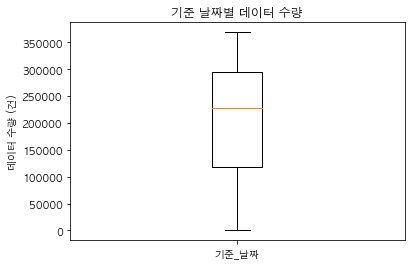

In [66]:
plt.boxplot(date_group['전체_건수'], labels=['기준_날짜'])
plt.ylabel("데이터 수량 (건)")
plt.title("기준 날짜별 데이터 수량")


In [69]:
date_group['기준_날짜'] = pd.to_datetime(date_group['기준_날짜'], format="%Y%m%d")

In [70]:
date_group

,기준_날짜,전체_건수
0,2022-01-01,55885
1,2022-01-02,56166
2,2022-01-03,106606
3,2022-01-04,111963
4,2022-01-05,114184
...,...,...
268,2022-09-26,360993
269,2022-09-27,367001
270,2022-09-28,368759
271,2022-09-29,358954


Text(0.5, 1.0, '기준일 내 존재하는 데이터 수량')

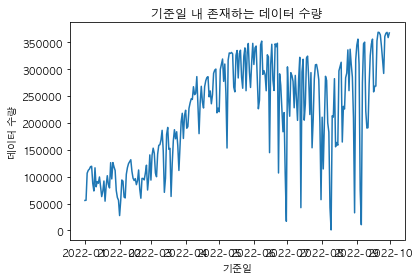

In [72]:
plt.plot(date_group['기준_날짜'], date_group['전체_건수'])
plt.xlabel("기준일")
plt.ylabel("데이터 수량")
plt.title("기준일 내 존재하는 데이터 수량")

* 위 그래프의 경우 기준일에 집계된 데이터의 수량으로 00:00 ~ 23:55 까지 5분 간격으로 각 정류소에서 대여 혹은 반납으로 집계된 데이터의 수량임.
* 대여 혹은 반납된 자전거의 수가 아님을 유의할 것
* 대여 혹은 반납이 발생되지 않은 경우("전체_건수" = 0)의 데이터는 집계되지 않았음을 확인할 수 있다.

#### 기준_집계: 
* 0: 시작 기준 집계
* 1: 종료 기준 집계

In [11]:
bicycle_df['기준_집계'].value_counts()

0    29410905
1    29224561
Name: 기준_집계, dtype: int64

In [42]:
print(f"시작 기준(0)이 종료 기준(1)보다 데이터가 {29410905-29224561} 개 많다.")

시작 기준(0)이 종료 기준(1)보다 데이터가 186344 개 많다.


#### 기준_시간대
: 집계가 이루어진 시간대를 의미, 5분 간격으로 진행

In [12]:
time_list = list(bicycle_df['기준_시간대'].unique())
if len(time_list) == (24*12):
    print("'기준_시간대'에 누락된 값은 없습니다.")
else:
    print("'기준_시간대'에 누락된 값이 존재합니다.")

'기준_시간대'에 누락된 값은 없습니다.


#### 시작_대여소_ID
: 자전거를 대여한 대여소 ID

In [9]:
start_station_group = pd.DataFrame(bicycle_df['시작_대여소_ID'].value_counts()).reset_index(drop=False)
start_station_group.columns = ['시작_대여소_ID', '데이터 수량']
print("시작 대여소 수량:", len(bicycle_df['시작_대여소_ID'].unique()))
print("시작 대여소별 데이터 수량:\n", start_station_group)

시작 대여소 수량: 2718
시작 대여소별 데이터 수량:
      시작_대여소_ID  데이터 수량
0      ST-2031  211847
1        ST-99  164814
2        ST-73  162382
3      ST-2905  162200
4       ST-891  150089
...        ...     ...
2713   ST-1750      10
2714   ST-2144       8
2715   ST-2695       8
2716    ST-498       6
2717   ST-2963       2

[2718 rows x 2 columns]


In [34]:
q1 = start_station_group['데이터 수량'].quantile(0.25)
q3 = start_station_group['데이터 수량'].quantile(0.75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3: {q3}\nIQR: {iqr}")

Q1: 8875.25
Q3: 28883.0
IQR: 20007.75


Text(0.5, 0, '대여소 ID')

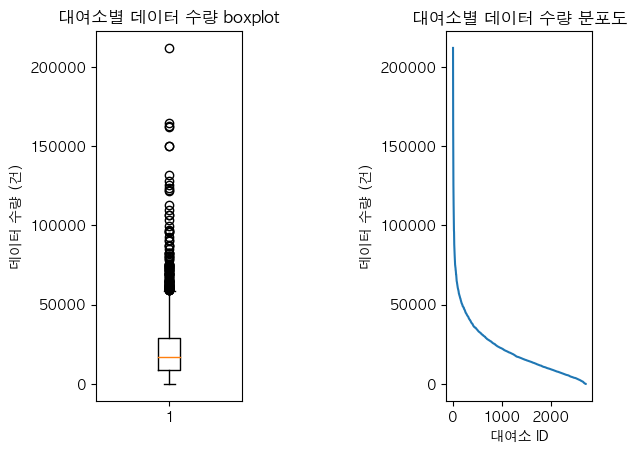

In [28]:
plt.subplot(131)
plt.boxplot(start_station_group['데이터 수량'])
plt.title("대여소별 데이터 수량 boxplot")
plt.ylabel("데이터 수량 (건)")
plt.vlines(q3+1.5*iqr, label=f"{}")

plt.subplot(133)
plt.plot(start_station_group['데이터 수량'])
plt.title("대여소별 데이터 수량 분포도")
plt.ylabel("데이터 수량 (건)")
plt.xlabel("대여소 ID")

대부분 대여소에서 발생한 데이터의 수량이 50000건을 넘지 않는다.

Text(0.5, 0, '데이터 수량')

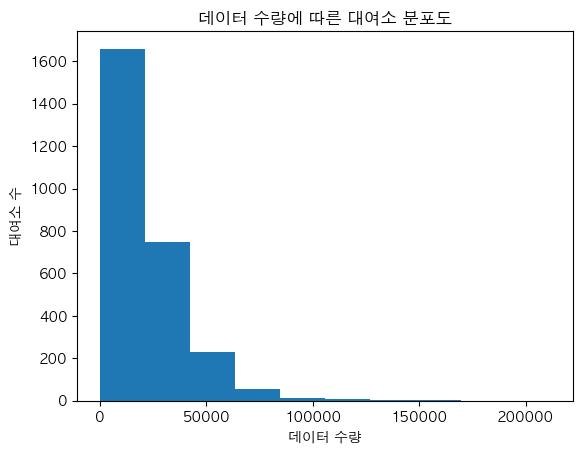

In [30]:
plt.hist(start_station_group['데이터 수량'])
plt.title("데이터 수량에 따른 대여소 분포도")
plt.ylabel("대여소 수")
plt.xlabel("데이터 수량")

대여소별 발생한 데이터 수량을 분포도로 확인해본 결과 약 2400곳의 대여소가 50000 건 이하의 데이터를 가지고 있다.